In [1]:
%matplotlib inline

## Load packages
import os
import pickle
import datetime
import numpy as np
import pandas as pd
from numba import jit

from tsmodel import TimeSeriesModel

from scipy import stats
from statsmodels.tsa import stattools
from statsmodels.tsa.stattools import acf, pacf, ARMA
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.ar_model import AutoReg
import statsmodels.api as sm

from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pylab
import seaborn as sns

# Some plotting defaults
sns.set(style="ticks", context="paper")
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'mathtext.default':'regular'}) 
plt.rcParams["figure.figsize"] = [10, 5]

# CCIWR class project
This code implements monte carlo simulation and prediction based on autoregressive processes.

In [2]:
# Load the data
mosul_usgs = pd.read_csv("data/USGS/MosulMonthly1931-1997.csv", sep=';', index_col = 'year')
mosul_usgs = mosul_usgs.unstack().reset_index()
mosul_usgs = mosul_usgs.rename(columns={"level_0": "month", 0: 'discharge_cmps'})
mosul_usgs['day'] = np.repeat(1, len(mosul_usgs))
mosul_usgs['tstamp'] = pd.to_datetime(mosul_usgs[['day', 'month', 'year']], format="%d%m%Y")
mosul_usgs = mosul_usgs.sort_values(by='tstamp').set_index('tstamp')['discharge_cmps']
mosul_usgs = mosul_usgs.fillna(value=mosul_usgs.mean())

In [3]:
# crude conversion based on philips report, but probably the best we can do within the scope of the project
# Ilisu dam flows = 85% of Mosul dam flows in an undisturbed flow regime upstream of Mosul dam
mosul2ilisu = 0.85
ilisu_usgs = mosul_usgs * mosul2ilisu

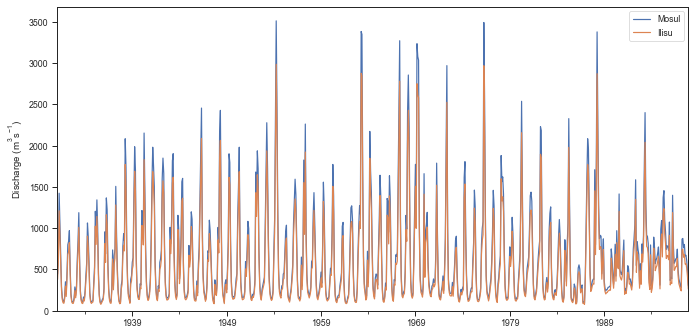

In [4]:
mosul_usgs.name = "Mosul"
ilisu_usgs.name = "Ilisu"

# plot
f, ax = plt.subplots()

# ts
ax = mosul_usgs.plot()
ilisu_usgs.plot(ax=ax)

# styling
ax.set_ylabel('Discharge ($m^3 s^{-1}$)')
ax.set_xlabel(None)
ax.set_ylim(0.)
plt.legend()
plt.tight_layout()
plt.savefig("plots/usgs_data_ts.png", dpi=300, bbox_inches = "tight")

No handles with labels found to put in legend.


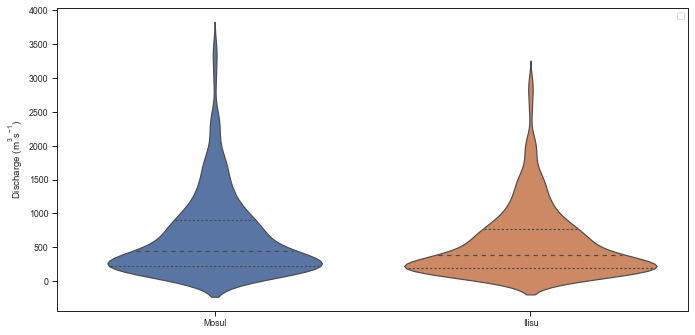

In [5]:
merged = pd.concat([mosul_usgs, ilisu_usgs], axis=1).melt(var_name='location', value_name='discharge')

# plot
ax = sns.violinplot(x="location", y="discharge", data=merged, inner="quartile")

# styling
ax.set_ylabel('Discharge ($m^3 s^{-1}$)')
ax.set_xlabel(None)
plt.legend()
plt.tight_layout()
plt.savefig("plots/usgs_data_violin.png", dpi=300, bbox_inches = "tight")

Calculate quantiles of the simulation distributions

# Monte carlo simulation for Mosul using USGS data

Text(0, 0.5, 'Discharge ($m^3 s^{-1}$)')

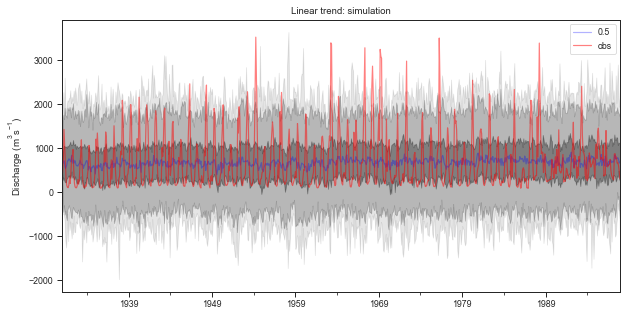

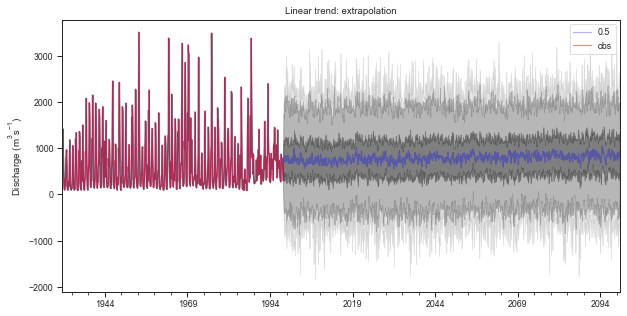

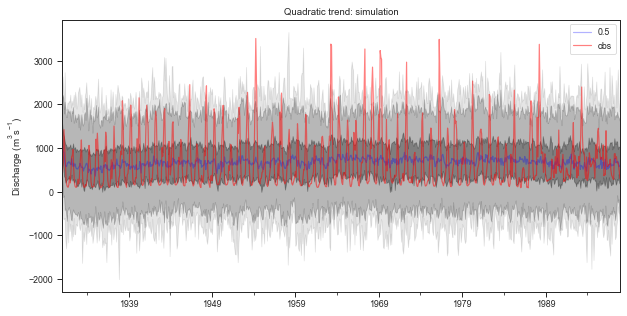

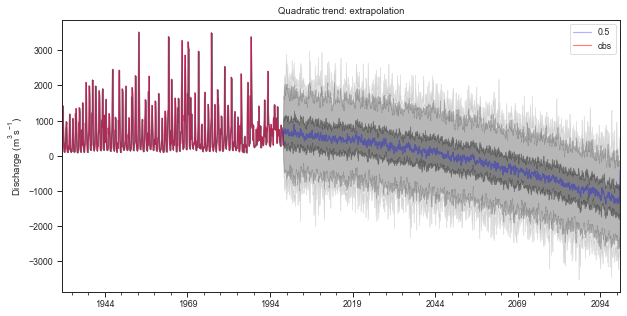

In [6]:
# run simulation
n_realisations = 100
until = '2099-12-31'
ts = mosul_usgs

# model with linear trend
model_mosul_usgs_linear = TimeSeriesModel(ts=ts)
model_mosul_usgs_linear = model_mosul_usgs_linear.fit(ar_order=1, pdeg=1)
model_mosul_usgs_linear = model_mosul_usgs_linear.monte_carlo(n=n_realisations)
model_mosul_usgs_linear = model_mosul_usgs_linear.extrapolate(until=until, n=n_realisations)

# model with quadratic trend
model_mosul_usgs_quadratic = TimeSeriesModel(ts=ts)
model_mosul_usgs_quadratic = model_mosul_usgs_quadratic.fit(ar_order=1, pdeg=2)
model_mosul_usgs_quadratic = model_mosul_usgs_quadratic.monte_carlo(n=n_realisations)
model_mosul_usgs_quadratic = model_mosul_usgs_quadratic.extrapolate(until=until, n=n_realisations)

# plots
ax = model_mosul_usgs_linear.plot(what='sim')
ax.set_title("Linear trend: simulation")
ax.set_ylabel("Discharge ($m^3 s^{-1}$)")
plt.savefig("plots/mosul_simulation.png", dpi=300, bbox_inches = "tight")

ax = model_mosul_usgs_linear.plot(what='extrp')
ax.set_title("Linear trend: extrapolation")
ax.set_ylabel("Discharge ($m^3 s^{-1}$)")
plt.savefig("plots/mosul_extrapolation.png", dpi=300, bbox_inches = "tight")

ax = model_mosul_usgs_quadratic.plot(what='sim')
ax.set_title("Quadratic trend: simulation")
ax.set_ylabel("Discharge ($m^3 s^{-1}$)")

ax = model_mosul_usgs_quadratic.plot(what='extrp')
ax.set_title("Quadratic trend: extrapolation")
ax.set_ylabel("Discharge ($m^3 s^{-1}$)")

# Using the simulation for Mosul based on USGS data to infer a simulation set at Ilisu

In [7]:
ts = ilisu_usgs

# model with linear trend
model_ilisu_usgs_linear = TimeSeriesModel(ts)
model_ilisu_usgs_linear = model_ilisu_usgs_linear.fit(ar_order=1, pdeg=1)
model_ilisu_usgs_linear = model_ilisu_usgs_linear.monte_carlo(n=n_realisations)
model_ilisu_usgs_linear = model_ilisu_usgs_linear.extrapolate(until=until, n=n_realisations)

# model with quadratic trend
model_ilisu_usgs_quadratic = TimeSeriesModel(ts=ts)
model_ilisu_usgs_quadratic = model_ilisu_usgs_quadratic.fit(ar_order=1, pdeg=2)
model_ilisu_usgs_quadratic = model_ilisu_usgs_quadratic.monte_carlo(n=n_realisations)
model_ilisu_usgs_quadratic = model_ilisu_usgs_quadratic.extrapolate(until=until, n=n_realisations)

**Model pacf's and trends**

In [8]:
print("Mosul PACF: ", model_mosul_usgs_linear.alpha)
print("Ilisu PACF: ", model_ilisu_usgs_linear.alpha)

print("Mosul beta1': ", model_mosul_usgs_linear.model_params[0])
print("Ilisu beta1': ", model_ilisu_usgs_linear.model_params[0])

Mosul PACF:  0.7027216226374097
Ilisu PACF:  0.7027216226374097
Mosul beta1':  0.11546249324677665
Ilisu beta1':  0.09814311925975977


Negative discharge doesn't make a whole lot of sense. Set values < 0 to 0.

In [9]:
model_mosul_usgs_linear.extrapolation = model_mosul_usgs_linear.extrapolation.where(model_mosul_usgs_linear.extrapolation > 0., 0.)
model_ilisu_usgs_linear.extrapolation = model_ilisu_usgs_linear.extrapolation.where(model_ilisu_usgs_linear.extrapolation > 0., 0.)

Store 100 extrapolations each

In [10]:
model_mosul_usgs_linear.extrapolation.to_csv("data/monte_carlo/model_mosul_usgs_linear.csv")
model_ilisu_usgs_linear.extrapolation.to_csv("data/monte_carlo/model_ilisu_usgs_linear.csv")

Calculate quantiles 

In [11]:
quantiles = [0., 0.025, 0.25, 0.5, 0.75, 0.975, 1.]
model_mosul_usgs_linear.quantiles = model_mosul_usgs_linear.extrapolation.quantile(q=quantiles, axis=1).T
model_ilisu_usgs_linear.quantiles = model_ilisu_usgs_linear.extrapolation.quantile(q=quantiles, axis=1).T

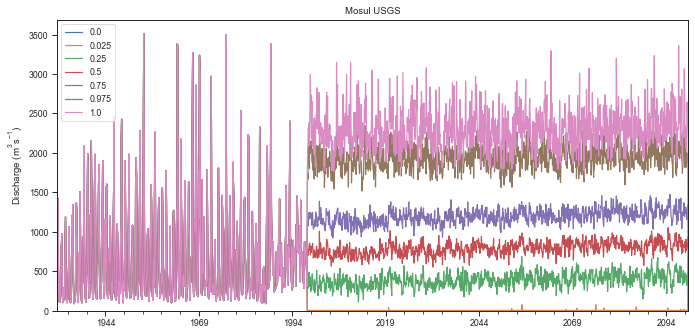

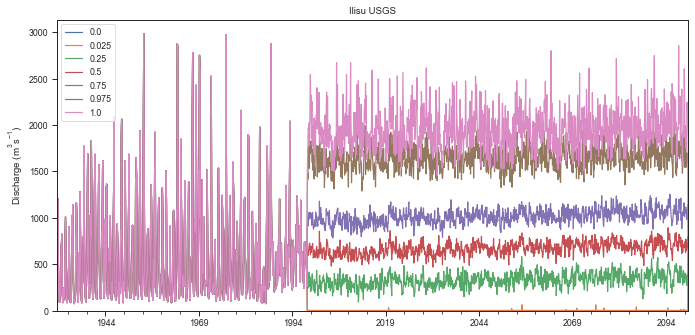

In [12]:
ax = model_mosul_usgs_linear.quantiles.plot(title="Mosul USGS")
ax.set_ylabel("Discharge ($m^3 s^{-1}$)")
ax.set_ylim(0.)
plt.tight_layout()
plt.savefig("plots/mosul_quantiles.png", dpi=300, bbox_inches = "tight")


ax = model_ilisu_usgs_linear.quantiles.plot(title="Ilisu USGS")
ax.set_ylabel("Discharge ($m^3 s^{-1}$)")
ax.set_ylim(0.)
plt.tight_layout()
plt.savefig("plots/ilisu_quantiles.png", dpi=300, bbox_inches = "tight")

In [13]:
model_mosul_usgs_linear.quantiles.to_csv("data/monte_carlo/quantiles_mosul_usgs_linear.csv")
model_ilisu_usgs_linear.quantiles.to_csv("data/monte_carlo/quantiles_ilisu_usgs_linear.csv")

## Discharge seasonality

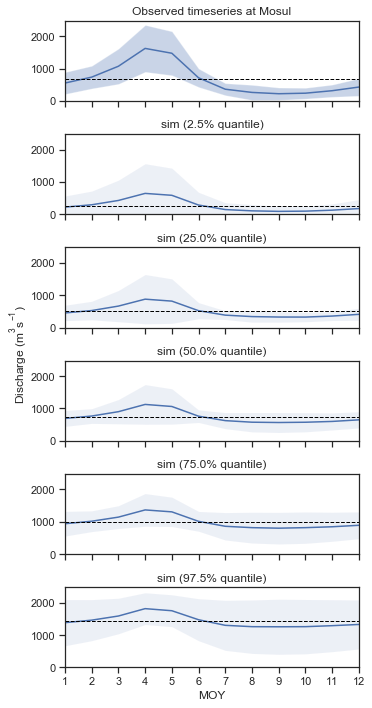

In [14]:
sns.set(style="ticks")
quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]
fig, axes = plt.subplots(nrows=len(quantiles)+1, sharex=True, sharey=True, figsize=(5,10))

# plot observations
ts_obs = model_mosul_usgs_linear.ts
climat_obs_mean = ts_obs.groupby(ts_obs.index.month).mean()
climat_obs_mean.name = "obs"
climat_obs_sd = ts_obs.groupby(ts_obs.index.month).std()
climat_obs_mean.plot(ax = axes[0])
axes[0].axhline(climat_obs_mean.mean(), linestyle="--", color="black", linewidth=1)
axes[0].fill_between(climat_obs_mean.index.values,
                climat_obs_mean - climat_obs_sd,
                climat_obs_mean + climat_obs_sd,
                alpha = 0.3)
axes[0].set_title("Observed timeseries at Mosul")

# plot simulations
ts_extrp = model_mosul_usgs_linear.quantiles
for q, ax in zip(quantiles, axes[1:]):
    ts_extrp_q = ts_extrp[q]
    climat_extrp_mean = ts_extrp_q.groupby(ts_extrp.index.month).mean()
    climat_extrp_sd = ts_extrp_q.groupby(ts_extrp.index.month).std()
    #climat_extrp_mean.name = "sim (q={})".format(q)
    
    # plot
    climat_extrp_mean.plot(ax = ax)
    ax.fill_between(climat_extrp_mean.index.values,
                    climat_extrp_mean - climat_extrp_sd,
                    climat_extrp_mean + climat_extrp_sd,
                    alpha = 0.1)
    ax.axhline(climat_extrp_mean.mean(), linestyle="--", color="black", linewidth=1)
    ax.set_title("sim ({:.1f}% quantile)".format(q*100))

# general
for ax in axes:
    ax.set_ylim(0.)
    ax.set_xlim(1,12)
    ax.set_xticks(range(1,13))
axes[-1].set_xlabel("MOY")

plt.tight_layout()
fig.text(-0.03, 0.5, 'Discharge ($m^3 s^{-1}$)', va='center', rotation='vertical')

plt.savefig("plots/mosul_seasonality.png", dpi=300, bbox_inches = "tight")

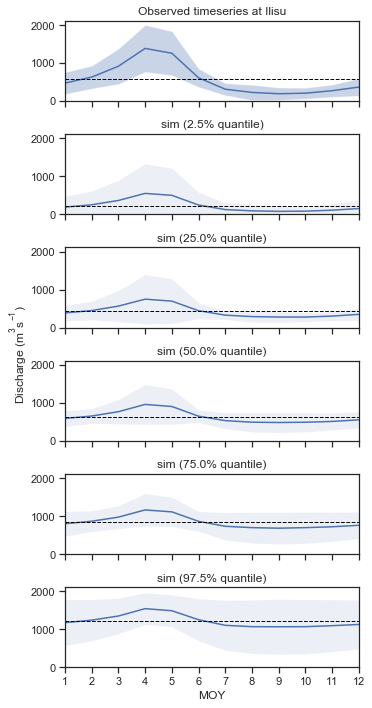

In [15]:
sns.set(style="ticks")
quantiles = [0.025, 0.25, 0.5, 0.75, 0.975]
fig, axes = plt.subplots(nrows=len(quantiles)+1, sharex=True, sharey=True, figsize=(5,10))

# plot observations
ts_obs = model_ilisu_usgs_linear.ts
climat_obs_mean = ts_obs.groupby(ts_obs.index.month).mean()
climat_obs_mean.name = "obs"
climat_obs_sd = ts_obs.groupby(ts_obs.index.month).std()
climat_obs_mean.plot(ax = axes[0])
axes[0].axhline(climat_obs_mean.mean(), linestyle="--", color="black", linewidth=1)
axes[0].fill_between(climat_obs_mean.index.values,
                climat_obs_mean - climat_obs_sd,
                climat_obs_mean + climat_obs_sd,
                alpha = 0.3)
axes[0].set_title("Observed timeseries at Ilisu")

# plot simulations
ts_extrp = model_ilisu_usgs_linear.quantiles
for q, ax in zip(quantiles, axes[1:]):
    ts_extrp_q = ts_extrp[q]
    climat_extrp_mean = ts_extrp_q.groupby(ts_extrp.index.month).mean()
    climat_extrp_sd = ts_extrp_q.groupby(ts_extrp.index.month).std()
    #climat_extrp_mean.name = "sim (q={})".format(q)
    
    # plot
    climat_extrp_mean.plot(ax = ax)
    ax.fill_between(climat_extrp_mean.index.values,
                    climat_extrp_mean - climat_extrp_sd,
                    climat_extrp_mean + climat_extrp_sd,
                    alpha = 0.1)
    ax.axhline(climat_extrp_mean.mean(), linestyle="--", color="black", linewidth=1)
    ax.set_title("sim ({:.1f}% quantile)".format(q*100))

# general
for ax in axes:
    ax.set_ylim(0.)
    ax.set_xlim(1,12)
    ax.set_xticks(range(1,13))
axes[-1].set_xlabel("MOY")

plt.tight_layout()
fig.text(-0.03, 0.5, 'Discharge ($m^3 s^{-1}$)', va='center', rotation='vertical')
plt.savefig("plots/ilisu_seasonality.png", dpi=300, bbox_inches = "tight")

comparison of seasonality of the first vs the last 30 years

In [16]:
# observations
ts_obs = ts_obs
climat_obs_mean = ts_obs.groupby(ts_obs.index.month).mean()
climat_obs_mean.name = "observed"
climat_obs_sd = ts_obs.groupby(ts_obs.index.month).std()

# simulations
q = 0.5
ts_extrp = ts_extrp
climat_extrp_mean = ts_extrp.groupby(ts_extrp.index.month).mean()
climat_extrp_sd = ts_extrp.groupby(ts_extrp.index.month).std()
climat_extrp_mean.name = "simulated"

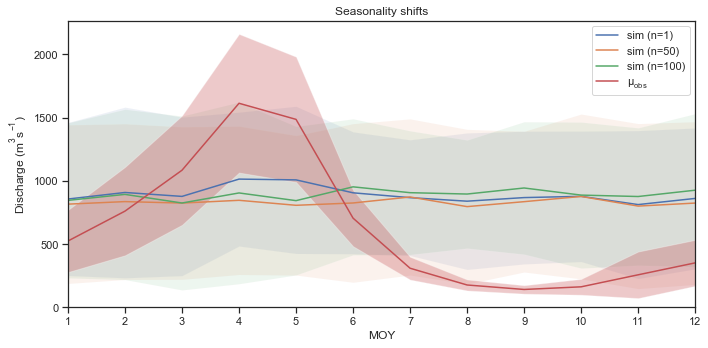

In [17]:
fig, ax = plt.subplots()

# simulations
ts_extrp = model_mosul_usgs_linear.extrapolation['2066-01-31':'2099-12-31']
for n in [1, 50, 100]:
    ts_extrp_q = ts_extrp[n]
    climat_extrp_mean = ts_extrp_q.groupby(ts_extrp.index.month).mean()
    climat_extrp_sd = ts_extrp_q.groupby(ts_extrp.index.month).std()
    climat_extrp_mean.name = "sim (n={})".format(n)
    
    # plot
    climat_extrp_mean.plot(ax = ax)
    ax.fill_between(climat_extrp_mean.index.values,
                    climat_extrp_mean - climat_extrp_sd,
                    climat_extrp_mean + climat_extrp_sd,
                    alpha = 0.1)
    
# observations from the first 30 years
ts_obs = model_mosul_usgs_linear.ts['1931-01-01':'1961-01-01']
climat_obs_mean = ts_obs.groupby(ts_obs.index.month).mean()
climat_obs_mean.name = "$\mu_{obs}$"
climat_obs_sd = ts_obs.groupby(ts_obs.index.month).std()

# plot
climat_obs_mean.plot(ax = ax)
ax.fill_between(climat_obs_mean.index.values,
                climat_obs_mean - climat_obs_sd,
                climat_obs_mean + climat_obs_sd,
                alpha = 0.3)

# general
ax.set_xlabel("MOY")
ax.set_ylabel("Discharge ($m^3 s^{-1}$)")
ax.set_title("Seasonality shifts")
ax.set_ylim(0.)
ax.set_xlim(1,12)
ax.set_xticks(range(1,13))

plt.legend()
plt.tight_layout()
plt.savefig("plots/mosul_seasonality_shifts.png", dpi=300, bbox_inches = "tight")

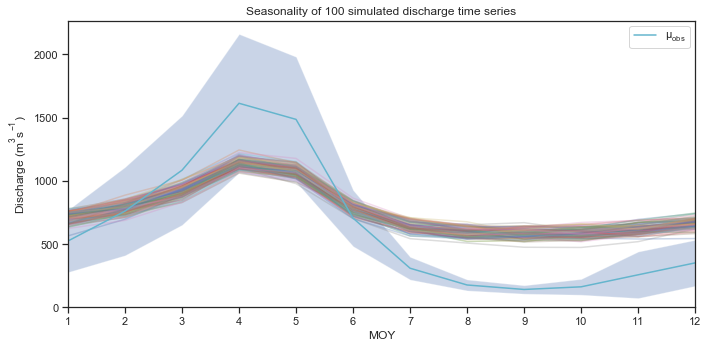

In [18]:
f, ax = plt.subplots()
for n in range(1, 100):
    ts = model_mosul_usgs_linear.extrapolation[n]
    ts_seas = ts.groupby(ts.index.month).mean()
    ts_seas.plot(ax=ax, legend=None, alpha=.3)
    
# plot
climat_obs_mean.plot(ax = ax, legend="$\mu_{obs}$")
ax.fill_between(climat_obs_mean.index.values,
                climat_obs_mean - climat_obs_sd,
                climat_obs_mean + climat_obs_sd,
                alpha = 0.3)
    
ax.set_xlabel("MOY")
ax.set_ylabel("Discharge ($m^3 s^{-1}$)")
ax.set_title("Seasonality of 100 simulated discharge time series")
ax.set_ylim(0.)
ax.set_xlim(1,12)
ax.set_xticks(range(1,13))
plt.tight_layout()
plt.savefig("plots/mosul_seasonality_of_extrapolations.png", dpi=300, bbox_inches = "tight")

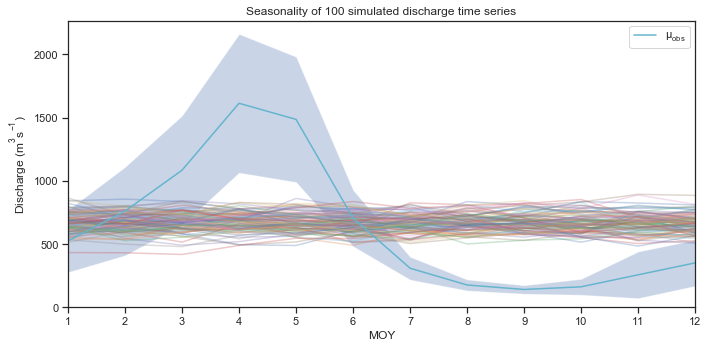

In [19]:
f, ax = plt.subplots()
for n in range(1, 100):
    ts = model_mosul_usgs_linear.simulation[n]
    ts_seas = ts.groupby(ts.index.month).mean()
    ts_seas.plot(ax=ax, legend=None, alpha=.3)
    
# plot
climat_obs_mean.plot(ax = ax, legend="$\mu_{obs}$")
ax.fill_between(climat_obs_mean.index.values,
                climat_obs_mean - climat_obs_sd,
                climat_obs_mean + climat_obs_sd,
                alpha = 0.3)
    
ax.set_xlabel("MOY")
ax.set_ylabel("Discharge ($m^3 s^{-1}$)")
ax.set_title("Seasonality of 100 simulated discharge time series")
ax.set_ylim(0.)
ax.set_xlim(1,12)
ax.set_xticks(range(1,13))
plt.tight_layout()
plt.savefig("plots/mosul_seasonality_of_simulations.png", dpi=300, bbox_inches = "tight")

## Operating policies

In [20]:
# phillips irrigation data
df_irr = pd.read_excel("data/irrigation/irrigation_main.xlsx", sheet_name="irrigation_requirement", header=13, index_col=0)
df_irr

,irrigation_requirement,diversion_upstream_existing,diversion_upstream_planned,diversion_downstream_planned,diversion_sum
month,,,,,
1,0.000,0.000000,0.000000,0.000000,0.000000
2,0.000,0.000000,0.000000,0.000000,0.000000
3,0.000,0.000000,0.000000,0.000000,0.000000
4,0.066,34.005376,92.405914,29.816308,156.227599
5,0.133,68.525986,186.211918,60.084379,314.822282
6,0.334,172.087814,467.629928,150.888590,790.606332
7,0.462,238.037634,646.841398,208.714158,1093.593190
8,0.390,200.940860,546.034946,176.187276,923.163082
9,0.187,96.348566,261.816756,84.479540,442.644863


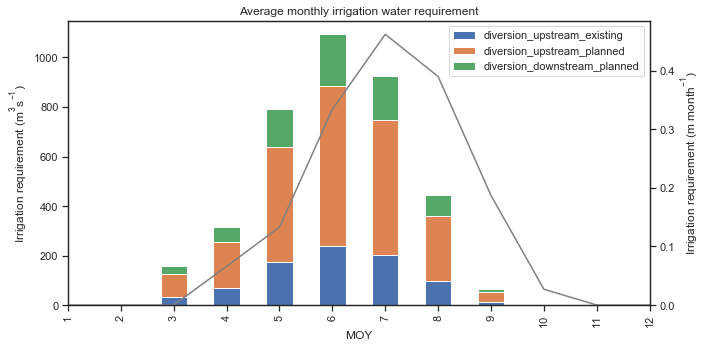

In [21]:
# water use plot
f, ax = plt.subplots()

# right y axis
twiny = ax.twinx()
df_irr.irrigation_requirement.plot(ax=twiny, color="grey")
twiny.set_ylabel("Irrigation requirement ($m~month^{-1}$)")
twiny.set_ylim(0.)

# left y axis
df_irr[['diversion_upstream_existing', 
        'diversion_upstream_planned', 
        'diversion_downstream_planned']].plot.bar(ax=ax, stacked=True)

# styling
ax.set_ylim(0.)
ax.set_xlim(1,12)
ax.set_xticks(range(1,13))
ax.set_xlabel("MOY")
ax.set_ylabel("Irrigation requirement ($m^3 s^{-1}$)")
plt.title("Average monthly irrigation water requirement")
plt.tight_layout()
plt.savefig("plots/irrigation_requirement.png", dpi=300, bbox_inches = "tight")

Discharge climatologies: average monthly mean flows for the different quantiles

In [22]:
mosul = model_mosul_usgs_linear.quantiles
climat_mosul_mean = mosul.groupby(mosul.index.month).mean()
climat_mosul_sd = mosul.groupby(mosul.index.month).std()

ilisu = model_ilisu_usgs_linear.quantiles
climat_ilisu_mean = ilisu.groupby(mosul.index.month).mean()
climat_ilisu_sd = ilisu.groupby(mosul.index.month).std()

**Approach**

1) start with the quantiles at ilisu.

In [23]:
climat_ilisu_mean

,0.000,0.025,0.250,0.500,0.750,0.975,1.000
1,187.248517,187.483109,383.533686,588.239528,798.595285,1175.381368,1370.164404
2,249.123432,249.274887,446.658786,651.356421,864.221503,1241.853923,1423.623016
3,362.668343,363.042414,564.084503,766.121281,972.236482,1350.842177,1536.370898
4,548.981302,549.055356,746.483519,957.237199,1161.762913,1544.974458,1736.199949
5,498.349970,498.616180,694.935640,903.154600,1110.831726,1489.863560,1702.158783
6,241.857692,242.394028,442.814964,647.236230,861.096330,1252.797017,1424.199717
7,122.776213,122.776213,325.583120,530.380803,730.649790,1105.323658,1291.960211
8,89.355621,89.355621,287.733585,489.006527,694.876589,1070.042225,1264.026845
9,75.714434,75.845471,275.975602,480.928116,681.120620,1067.235532,1274.601510
10,81.346006,81.606038,274.976421,488.088896,695.094730,1070.263255,1249.449722


2) subtract the water requirements of the upstream irrigation schemes

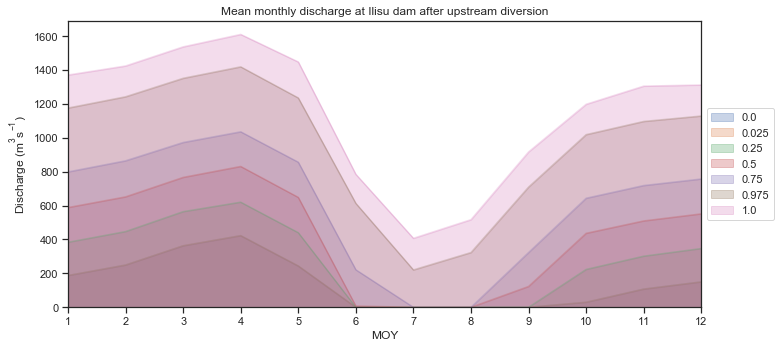

In [24]:
climat_ilisu_mean_after_upstream_diversion = climat_ilisu_mean.subtract(df_irr.diversion_upstream_existing + df_irr.diversion_upstream_planned, axis=0)
climat_ilisu_mean_after_upstream_diversion[climat_ilisu_mean_after_upstream_diversion < 0] = 0.

# plot
ax = climat_ilisu_mean_after_upstream_diversion.plot.area(stacked=False, alpha=.3)
ax.set_xlabel("MOY")
ax.set_ylabel("Discharge ($m^3 s^{-1}$)")
ax.set_ylim(0.)
ax.set_xlim(1,12)
ax.set_xticks(range(1,13))

# shrink axis by 20% and put the legend to the right of the plot
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("Mean monthly discharge at Ilisu dam after upstream diversion")
plt.tight_layout()

3) from the remaining flows, subtract the downstream water requirements at Cizre

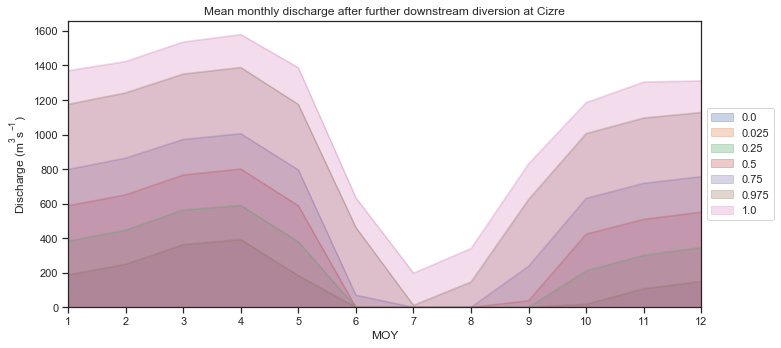

In [25]:
climat_ilisu_mean_after_total_diversion = climat_ilisu_mean_after_upstream_diversion.subtract(df_irr.diversion_downstream_planned, axis=0)
climat_ilisu_mean_after_total_diversion[climat_ilisu_mean_after_total_diversion < 0] = 0.

# plot
ax = climat_ilisu_mean_after_total_diversion.plot.area(stacked=False, alpha=.3)
ax.set_xlabel("MOY")
ax.set_ylabel("Discharge ($m^3 s^{-1}$)")
ax.set_ylim(0.)
ax.set_xlim(1,12)
ax.set_xticks(range(1,13))

# shrink axis by 20% and put the legend to the right of the plot
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("Mean monthly discharge after further downstream diversion at Cizre")
plt.tight_layout()

4) multiply that number by 100%/85% = 1.17 (Phillips Report Assumption) to obtain the flows at mosul minus irrigation in turkey (neglecting irrigation in iraq). Note: we could also just report the amount of water flowing over the turkish-iraqi border

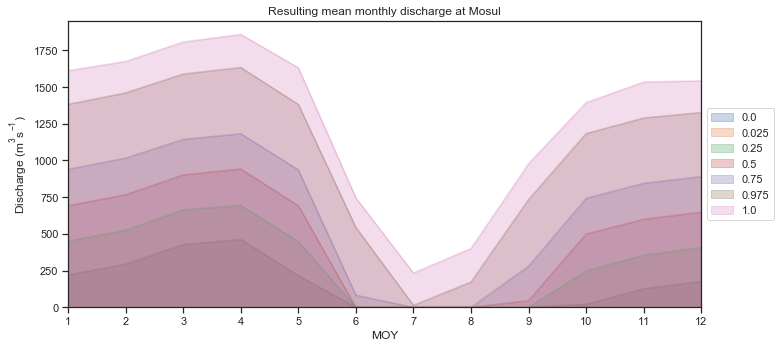

In [26]:
ilisu2mosul = 100/85
climat_mosul_mean_after_total_diversion = climat_ilisu_mean_after_total_diversion * ilisu2mosul

# plot
ax = climat_mosul_mean_after_total_diversion.plot.area(stacked=False, alpha=.3)
ax.set_xlabel("MOY")
ax.set_ylabel("Discharge ($m^3 s^{-1}$)")
ax.set_ylim(0.)
ax.set_xlim(1,12)
ax.set_xticks(range(1,13))

# shrink axis by 20% and put the legend to the right of the plot
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("Resulting mean monthly discharge at Mosul")
plt.tight_layout()

**1) Minimum monthly average outflow: 60-100 m^3 / s** (UEAIR and General Directorate of Turkish Hydraulic Works (DSI))

**2) Above-the-mean: minimum release equal to the long term mean flow, only excess water can be stored in Ilisu dam reservoir**

**3) Percent of natural flow regime: impact of deviation (5-30%) from natural, undisturbed flows**

Area plots

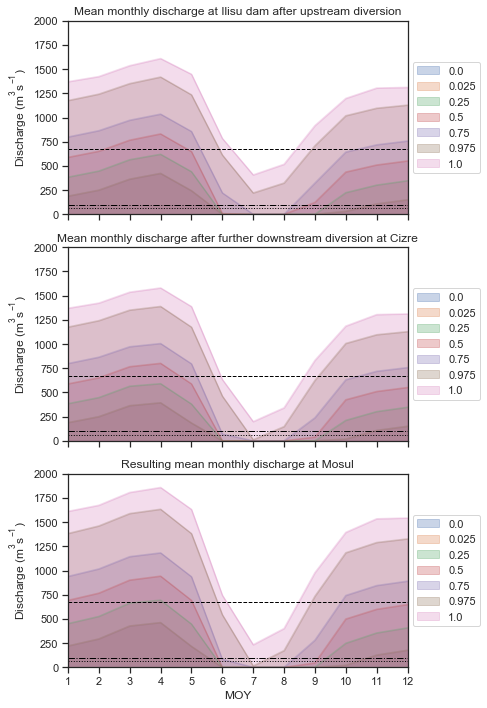

In [27]:
# minimum flows
min_flow_60 = 60
min_flow_100 = 100
long_term_mean_obs = mosul_usgs.mean()

# plot
f, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharey=True, sharex=True, figsize=(6,10))

# 1) Above Ilisu
climat_ilisu_mean_after_upstream_diversion.plot.area(ax=ax1, stacked=False, alpha=.3)
ax1.set_title("Mean monthly discharge at Ilisu dam after upstream diversion")

# 2) Cizre
climat_ilisu_mean_after_total_diversion.plot.area(ax=ax2, stacked=False, alpha=.3)
ax2.set_title("Mean monthly discharge after further downstream diversion at Cizre")

# 3) Mosul
climat_mosul_mean_after_total_diversion.plot.area(ax=ax3, stacked=False, alpha=.3)
ax3.set_title("Resulting mean monthly discharge at Mosul")

# general
for ax in [ax1, ax2, ax3]:
    # 60 m^3/s min flow
    ax.axhline(min_flow_60, linestyle="dotted", color="black", linewidth=1)
    
    # 100 m^3/s min flow
    ax.axhline(min_flow_100, linestyle="dashdot", color="black", linewidth=1)
    
    # above-the-mean
    ax.axhline(long_term_mean_obs, linestyle="dashed", color="black", linewidth=1)
    
    # styling
    ax.set_xlabel("MOY")
    ax.set_ylabel("Discharge ($m^3 s^{-1}$)")
    ax.set_ylim(0., 2000.)
    ax.set_xlim(1,12)
    ax.set_xticks(range(1,13))

    # shrink axis by 20% and put the legend to the right of the plot
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig("plots/operation_policies_areachart.png", dpi=300, bbox_inches = "tight")

Line plots

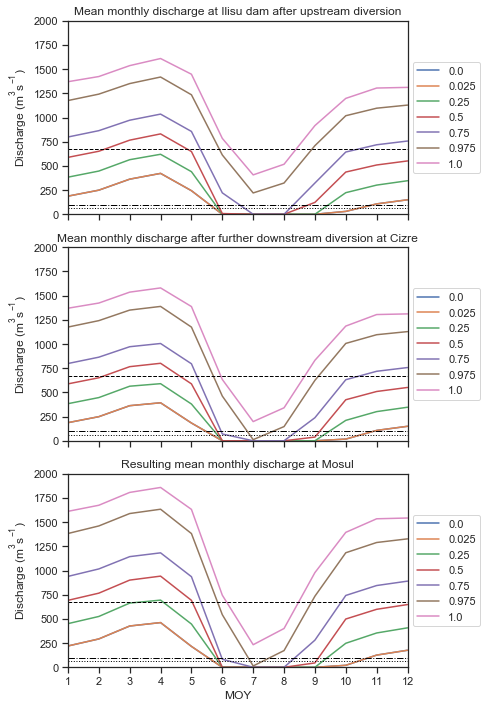

In [28]:
# minimum flows
min_flow_60 = 60
min_flow_100 = 100
long_term_mean_obs = mosul_usgs.mean()

# plot
f, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharey=True, sharex=True, figsize=(6,10))

# 1) Above Ilisu
climat_ilisu_mean_after_upstream_diversion.plot(ax=ax1)
ax1.set_title("Mean monthly discharge at Ilisu dam after upstream diversion")

# 2) Cizre
climat_ilisu_mean_after_total_diversion.plot(ax=ax2)
ax2.set_title("Mean monthly discharge after further downstream diversion at Cizre")

# 3) Mosul
climat_mosul_mean_after_total_diversion.plot(ax=ax3)
ax3.set_title("Resulting mean monthly discharge at Mosul")

# general
for ax in [ax1, ax2, ax3]:
    # 60 m^3/s min flow
    ax.axhline(min_flow_60, linestyle="dotted", color="black", linewidth=1)
    
    # 100 m^3/s min flow
    ax.axhline(min_flow_100, linestyle="dashdot", color="black", linewidth=1)
    
    # above-the-mean
    ax.axhline(long_term_mean_obs, linestyle="dashed", color="black", linewidth=1)
    
    # styling
    ax.set_xlabel("MOY")
    ax.set_ylabel("Discharge ($m^3 s^{-1}$)")
    ax.set_ylim(0., 2000.)
    ax.set_xlim(1,12)
    ax.set_xticks(range(1,13))

    # shrink axis by 20% and put the legend to the right of the plot
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig("plots/operation_policies_linechart.png", dpi=300, bbox_inches = "tight")

Bar plots

670.2109725685785


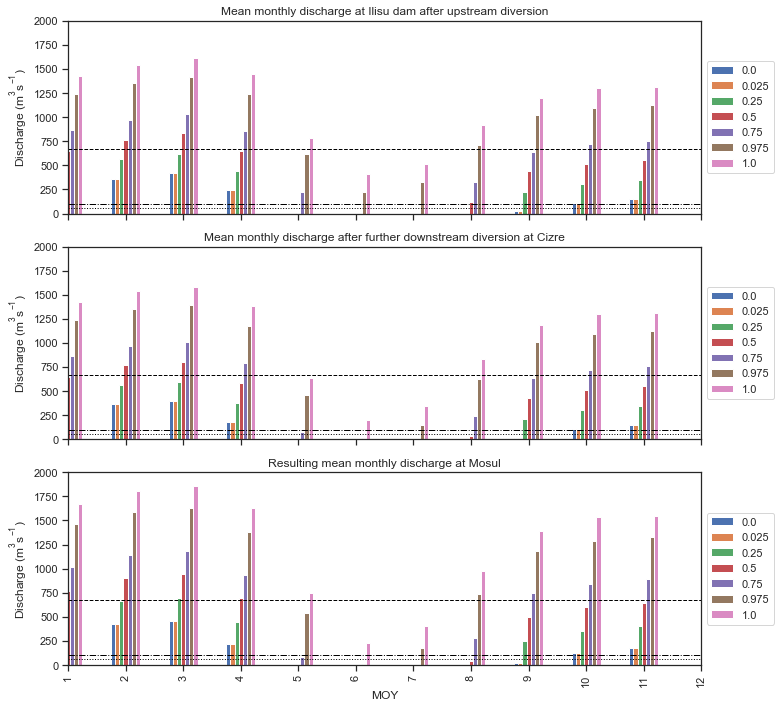

In [31]:
# minimum flows
min_flow_60 = 60
min_flow_100 = 100
long_term_mean_obs = mosul_usgs.mean()
print(long_term_mean_obs)

# plot
f, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharey=True, sharex=True, figsize=(10,10))

# 1) Above Ilisu
climat_ilisu_mean_after_upstream_diversion.plot.bar(ax=ax1)
ax1.set_title("Mean monthly discharge at Ilisu dam after upstream diversion")

# 2) Cizre
climat_ilisu_mean_after_total_diversion.plot.bar(ax=ax2)
ax2.set_title("Mean monthly discharge after further downstream diversion at Cizre")

# 3) Mosul
climat_mosul_mean_after_total_diversion.plot.bar(ax=ax3)
ax3.set_title("Resulting mean monthly discharge at Mosul")

# general
for ax in [ax1, ax2, ax3]:
    # 60 m^3/s min flow
    ax.axhline(min_flow_60, linestyle="dotted", color="black", linewidth=1)
    
    # 100 m^3/s min flow
    ax.axhline(min_flow_100, linestyle="dashdot", color="black", linewidth=1)
    
    # above-the-mean
    ax.axhline(long_term_mean_obs, linestyle="dashed", color="black", linewidth=1)
    
    # styling
    ax.set_xlabel("MOY")
    ax.set_ylabel("Discharge ($m^3 s^{-1}$)")
    ax.set_ylim(0., 2000.)
    ax.set_xlim(1,12)
    ax.set_xticks(range(1,13))

    # shrink axis by 20% and put the legend to the right of the plot
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig("plots/operation_policies_barchart.png", dpi=300, bbox_inches = "tight")